# Identifying Entities in Healthcare Data

### Install and Import Dependencies

In [1]:
!pip install sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00


In [2]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

### Upload datafiles to colab

In [3]:
from google.colab import files
files.upload()

Saving test_label to test_label
Saving test_sent to test_sent
Saving train_label to train_label
Saving train_sent to train_sent


{'test_label': b'O\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\n\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\n\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\n\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\n\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\n\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\n\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\n\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\n\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nD\nD\n\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nD\nD\nO\nO\nO\nO\nO\nO\nO\nO\n\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\nO\n

### Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**

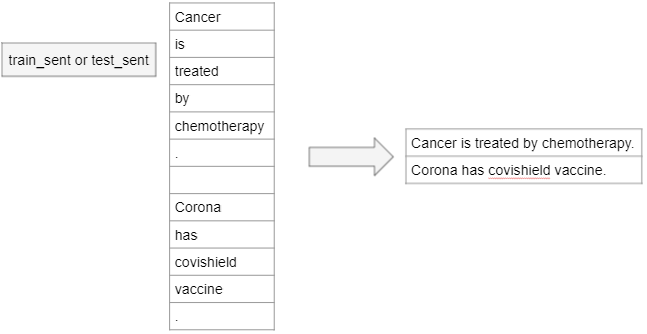

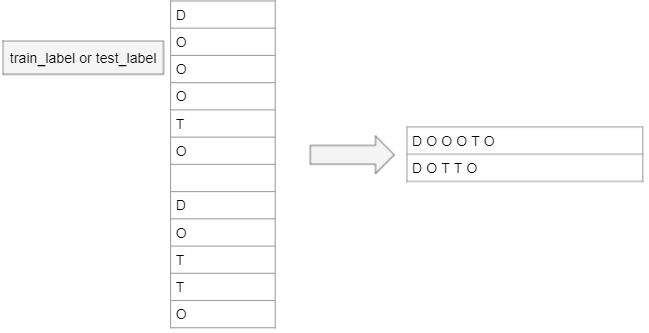

1. Create a function to construct proper sequences from individual words and their corresponding labels.

In [4]:
def prepare_data(filename):
  # list to store the sequences (sentences or labels)
  ls_seq = []
  # list to store each sequence
  seq = []
  with open(filename, 'r') as file:
    for word in file:
      word = word.strip()
      if word:
        # if non-empty line, append each word of the current sequence to 'seq' list
        seq.append(word)
      else:
        # If empty line, append the last detected sequence to 'ls_seq' list
        ls_seq.append(' '.join(seq))
        # delete the last sequence from the 'seq' list.
        seq.clear()
  return ls_seq

2. Call aforementioned function to prepare the datasets.

In [5]:
train_sentences = prepare_data('train_sent')
train_labels = prepare_data('train_label')
test_sentences = prepare_data('test_sent')
test_labels = prepare_data('test_label')

3. Print five train sentences along with their labels

In [6]:
num_seq = 5
sentence_num = 0
while num_seq:
  print(f'Train Sentence-{sentence_num+1}:\n{train_sentences[sentence_num]}\n')
  print(f'Sequence of labels for Train Sentence-{sentence_num+1}:\n{train_labels[sentence_num]}')
  num_seq-=1
  sentence_num+=1
  if not num_seq:
    num_seq = 5
    sentence_num = 0
    break
  else:
    print('\n=====================================================================\n')

Train Sentence-1:
All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )

Sequence of labels for Train Sentence-1:
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


Train Sentence-2:
The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )

Sequence of labels for Train Sentence-2:
O O O O O O O O O O O O O O O O O O O O O O O O O


Train Sentence-3:
Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )

Sequence of labels for Train Sentence-3:
O O O O O O O O O O O O O O O


Train Sentence-4:
The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )

Sequence of labels for Train

4. Print five test sentences along with their labels

In [7]:
while num_seq:
  print(f'Test Sentence-{sentence_num+1}:\n{test_sentences[sentence_num]}\n')
  print(f'Sequence of labels for Test Sentence-{sentence_num+1}:\n{test_labels[sentence_num]}')
  num_seq-=1
  sentence_num+=1
  if not num_seq:
    break
  else:
    print('\n=====================================================================\n')

Test Sentence-1:
Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )

Sequence of labels for Test Sentence-1:
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


Test Sentence-2:
As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration

Sequence of labels for Test Sentence-2:
O O O O O O O O O O O O O O O O O O O


Test Sentence-3:
The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period

Sequence of labels for Test Sentence-3:
O O O O O O O O O O O O O O O O O O O O O O O O


Test Sentence-4:
There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )

Seque

5. Count the number of sentences in the processed train and test dataset

In [8]:
print("No. of lines in train_sentences:", len(train_sentences))
print("No. of lines in test_sentences:", len(test_sentences))

No. of lines in train_sentences: 2599
No. of lines in test_sentences: 1056


6. Count the number of lines of labels in the processed train and test dataset.

In [9]:
print("No. of lines in train_labels:", len(train_labels))
print("No. of lines in test_labels:", len(test_labels))

No. of lines in train_labels: 2599
No. of lines in test_labels: 1056


### Concept Identification:<br>An important point to note here is that we are using both test and train sentences for concept identification. This is an exploratory analysis on the complete data.

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.

1. Create a function that ***spaCy*** to extract tokens that have NOUN or PROPN as their PoS tags and find their frequency from the ___entire dataset___ (by considering the train and the test dataset as a single unit of data). <br>It is good to identify all the words from the corpus that have a tag of NOUN or PROPN (nouns) and prepare a dictionary of their counts.

In [10]:
# load the the spacy model
model = spacy.load("en_core_web_sm")

In [11]:
def concept_identification(train, test):
  # collect the train and the test dataset as a single unit of data
  entire_corpus = ' '.join(train + test)

  # process the corpus by spacy model; run corpus into 'en_core_web_sm' model for POS tagging
  doc = model(entire_corpus)

  # Get all words tagged with NOUN and PROPN. Store them in a dictionary with their frequency of occurrence
  tokens_of_interest = {}
  for token in doc:
    if token.pos_ in ['NOUN', 'PROPN']:
      # print(token.text, tokens_of_interest.get(token.text, 0)+1)
      tokens_of_interest.update({token.text: tokens_of_interest.get(token.text, 0)+1}) #increase its frequency if it is noun
  else:
    return tokens_of_interest

2. Call the aforementioned function to create a dictionary of unique tokens that are tagged with NOUN and PROPN along with their counts in the entire corpus (train + test)

In [12]:
dict_nouns = concept_identification(train_sentences, test_sentences)

3. Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [13]:
dict(sorted(dict_nouns.items(), key=lambda x:x[1], reverse=True)[:25])

{'patients': 492,
 'treatment': 281,
 '%': 247,
 'cancer': 200,
 'therapy': 175,
 'study': 154,
 'disease': 142,
 'cell': 140,
 'lung': 116,
 'group': 94,
 'gene': 88,
 'chemotherapy': 88,
 'effects': 85,
 'results': 78,
 'women': 77,
 'use': 74,
 'risk': 71,
 'cases': 71,
 'surgery': 71,
 'analysis': 70,
 'TO_SEE': 70,
 'rate': 67,
 'response': 66,
 'survival': 65,
 'children': 64}

### Defining the features for CRF:

- Create a function to get the CRF features with the PoS tag as one of the features.
- While defining the features in which we have used the PoS tags, we also need to consider the preceding word of the current word. The use of the information of the preceding word makes the CRF model more accurate and exhaustive.
- Mark the beginning and the end words of a sentence correctly in the form of features.
- Source: https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html

In [14]:
def getFeaturesForOneWord(sentence, pos, pos_tags):
  word = sentence[pos]

  #Define 12 features with PoS tag as one of the features
  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.pos=' + pos_tags[pos]
  ]

  #Use the previous word also while defining features
  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(),
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word.pos=' + pos_tags[pos-1]
  ])
  # Mark the begining and the end words of a sentence correctly in the form of features.
  else:
    features.append('BEG') # feature to track begin of sentence

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence
  return features

### Getting the features and the labels of sentences

1. **Create a code/function to get the features' value of a sentence using the 'getFeaturesForOneWord' function (defined above)**

In [15]:
def getFeaturesForOneSentence(sentence):
  pos_processed_sentence = model(sentence) #spacy is applied to sentence
  pos_tags = [] #correctly identify pos tags
  for token in pos_processed_sentence:
    pos_tags.append(token.pos_)

  sentence_list = sentence.split() # List of words in sentence

  #Correctly calling getFeaturesForOneWord defined above
  return [getFeaturesForOneWord(sentence_list, pos, pos_tags) for pos in range(len(sentence_list))]

2. Verify if the above function to generate the CRF features works correctly by executing it for a sentence.

In [16]:
getFeaturesForOneSentence(train_sentences[22])

[['word.lower=trisomy',
  'word[-3:]=omy',
  'word[-2:]=my',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=True',
  'word.pos=NOUN',
  'BEG'],
 ['word.lower=21',
  'word[-3:]=21',
  'word[-2:]=21',
  'word.isupper=False',
  'word.isdigit=True',
  'word.startsWithCapital=False',
  'word.pos=NUM',
  'prev_word.lower=trisomy',
  'prev_word.isupper=False',
  'prev_word.isdigit=False',
  'prev_word.startsWithCapital=True',
  'prev_word.pos=NOUN'],
 ['word.lower=presented',
  'word[-3:]=ted',
  'word[-2:]=ed',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.pos=VERB',
  'prev_word.lower=21',
  'prev_word.isupper=False',
  'prev_word.isdigit=True',
  'prev_word.startsWithCapital=False',
  'prev_word.pos=NUM'],
 ['word.lower=with',
  'word[-3:]=ith',
  'word[-2:]=th',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.pos=ADP',
  'prev_word.lower=presented',
  'prev_word.isupper=False',

2. **Create a code/function to get the list of all labels of a sentence**

In [17]:
def getLabelsInListForOneSentence(labels):
  return labels.split()

### <u>Defining input and target variables</u>: <br>*Correctly computing X and Y sequence matrices for training and test data.*<br>*Check that both sentences and labels are processed*



1. **Extract the features' values for each sentence as an input variable for the CRF model in the test and the train dataset.**

In [18]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

In [19]:
X_train[10]

[['word.lower=a',
  'word[-3:]=A',
  'word[-2:]=A',
  'word.isupper=True',
  'word.isdigit=False',
  'word.startsWithCapital=True',
  'word.pos=DET',
  'BEG'],
 ['word.lower=2-',
  'word[-3:]=2-',
  'word[-2:]=2-',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.pos=NUM',
  'prev_word.lower=a',
  'prev_word.isupper=True',
  'prev_word.isdigit=False',
  'prev_word.startsWithCapital=True',
  'prev_word.pos=DET'],
 ['word.lower=,',
  'word[-3:]=,',
  'word[-2:]=,',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.pos=PUNCT',
  'prev_word.lower=2-',
  'prev_word.isupper=False',
  'prev_word.isdigit=False',
  'prev_word.startsWithCapital=False',
  'prev_word.pos=NUM'],
 ['word.lower=3-',
  'word[-3:]=3-',
  'word[-2:]=3-',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.pos=NUM',
  'prev_word.lower=,',
  'prev_word.isupper=False',
  'prev_word.isdigit=False',
  'prev_

In [20]:
X_test[100]

[['word.lower=the',
  'word[-3:]=The',
  'word[-2:]=he',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=True',
  'word.pos=DET',
  'BEG'],
 ['word.lower=effectiveness',
  'word[-3:]=ess',
  'word[-2:]=ss',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.pos=NOUN',
  'prev_word.lower=the',
  'prev_word.isupper=False',
  'prev_word.isdigit=False',
  'prev_word.startsWithCapital=True',
  'prev_word.pos=DET'],
 ['word.lower=of',
  'word[-3:]=of',
  'word[-2:]=of',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.pos=ADP',
  'prev_word.lower=effectiveness',
  'prev_word.isupper=False',
  'prev_word.isdigit=False',
  'prev_word.startsWithCapital=False',
  'prev_word.pos=NOUN'],
 ['word.lower=treatment',
  'word[-3:]=ent',
  'word[-2:]=nt',
  'word.isupper=False',
  'word.isdigit=False',
  'word.startsWithCapital=False',
  'word.pos=NOUN',
  'prev_word.lower=of',
  'prev_word.isupper=

2. **Extract the labels as the target variable for the test and the train dataset.**

In [21]:
y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]
y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

In [22]:
print(y_train[10])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [23]:
print(y_test[100])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### <u>Building the model</u>: <br>*We need to build the CRF model for a custom NER application using the features and the target variables.*

In [24]:
%%time
crf = sklearn_crfsuite.CRF(max_iterations=1000, algorithm='lbfgs')
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass
except Exception as e:
  raise

CPU times: user 9.7 s, sys: 64.1 ms, total: 9.76 s
Wall time: 9.86 s


### <u>Model Evaluation</u>

1. ***Predict the labels of each of the tokens in each sentence of the test dataset that has been preprocessed earlier***.

In [25]:
y_pred = crf.predict(X_test)

2. ***Calculate the f1 score using the actual and the predicted labels of the test dataset.***

In [26]:
metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.9099782276018558

### <u>Identifying Diseases and Treatments using Custom NER</u>

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.

1. ***Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.***

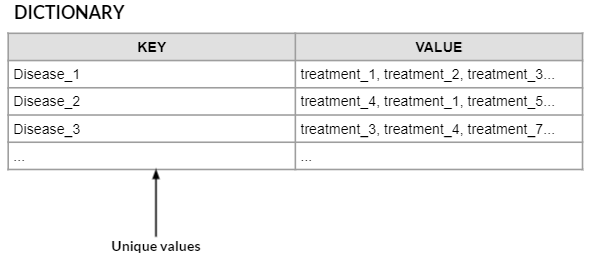

In [27]:
diseases_and_treatments =  {} # dictionary with disease as key an list of treatments as value

for i in range(len(y_pred)): # For each predicted sequence
  labels = y_pred[i]

  disease = "";
  treatment = "";

  for j in range(len(labels)): # for each individual label in the sequence
    if labels[j] == 'O': # ignore if label is O -- other
      continue

    if(labels[j] == 'D'): # Label D indicates disease, so add the corresponding word from test sentence to the disease name string
      disease += test_sentences[i].split()[j] + " "
      continue

    if(labels[j] == 'T'): # Label T indicates disease, so add the corresponding word from test sentence to the treatment name string
      #print(test_sentences[i].split()[j])
      treatment += test_sentences[i].split()[j] + " "

  disease = disease.strip() # to remove extraneous spaces
  treatment = treatment.strip()

  # add the identified disease and treatment to the dictionary
  # if it is a new disease, directly add the value
  # if the disease has been seen previously, get the treatment list and add current treatment to the list.
  if disease != "" and treatment != "":
    if disease not in diseases_and_treatments.keys():
      diseases_and_treatments[disease] = [treatment]
    else:
      treatment_list = diseases_and_treatments.get(disease)
      treatment_list.append(treatment)
      diseases_and_treatments[disease] = treatment_list

2. **Predict the treatment for the disease name: <br>hereditary retinoblastoma**

In [28]:
disease_name = 'hereditary retinoblastoma'
print(f'Treatment for the disease "{disease_name}" is {diseases_and_treatments.get(disease_name, "UNKNOWN")}')

Treatment for the disease "hereditary retinoblastoma" is ['radiotherapy']
